# Plots for Siggi Paper

### Simple examples of information gain

In [1]:
# First import code
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Set up red and blue spectra

In [3]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [4]:
def flat_prior_2(z):
    return 0.5

In [5]:
sig_example = siggi([red_spec, blue_spec], [0.5, 0.5], flat_prior_2,
                    z_min=0.0, z_max=0.0, z_steps=1)

In [6]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [7]:
%%time
test_rand_state = np.random.RandomState(42)
num_filters = 2
set_ratio = 0.5
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=15,
                                   optimizer_verbosity=5,
                                   procs=4, acq_func_kwargs_dict={'kappa':1.8},
                                   frozen_filt_dict = None,
                                   starting_points = [[mid-60., mid+60., mid_2-60., mid_2+60.] for mid, mid_2 in point_list],
                                   rand_state=test_rand_state)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   42.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 758 out of 758 | elapsed:  1.9min finished


-1.0 758
CPU times: user 2min 19s, sys: 8.16 s, total: 2min 27s
Wall time: 3min 41s


##### Providing a random seed introduces reproducibility as long as the same number of processors are used in parallelization.

In [8]:
%%time
test_rand_state = np.random.RandomState(42)
num_filters = 2
set_ratio = 0.5
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=15,
                                   optimizer_verbosity=5,
                                   procs=4, acq_func_kwargs_dict={'kappa':1.8},
                                   frozen_filt_dict = None,
                                   starting_points = [[mid-60., mid+60., mid_2-60., mid_2+60.] for mid, mid_2 in point_list],
                                   rand_state=test_rand_state)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 758 out of 758 | elapsed:  2.0min finished


-1.0 758
CPU times: user 2min 12s, sys: 8.01 s, total: 2min 20s
Wall time: 3min 39s


### Make plots

In [9]:
min_idx = np.argmin(res.yi)

best_pt = res.Xi[min_idx]

In [10]:
best_val = np.min(res.yi)

In [11]:
print(best_pt, best_val)

[365.0, 485.0, 715.0, 835.0] -1.0


In [12]:
sig_plot = plotting([red_spec, blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0, sky_mag=21.2)

Text(0, 0.5, 'Filter 2 Center Wavelength (nm)')

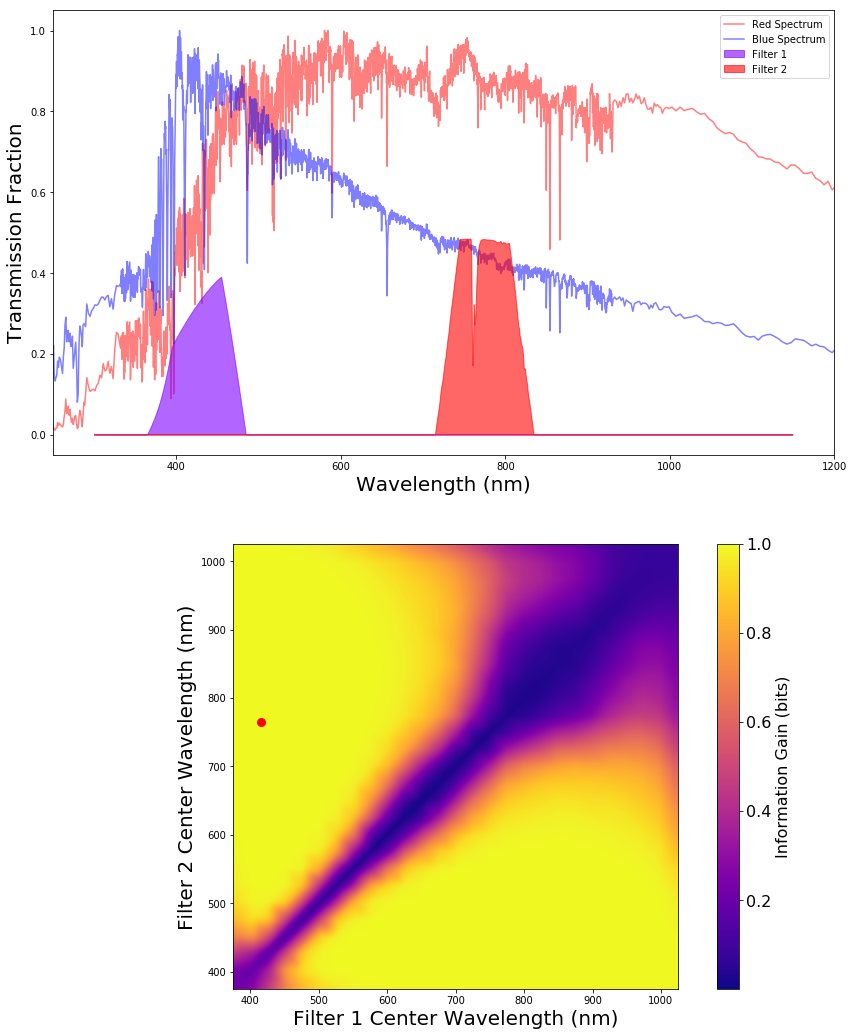

In [13]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Red Spectrum', 'Blue Spectrum', 'Filter 1', 'Filter 2'), loc=1)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res.Xi[:-3], np.abs(res.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
#plt.savefig('Example_1.pdf')

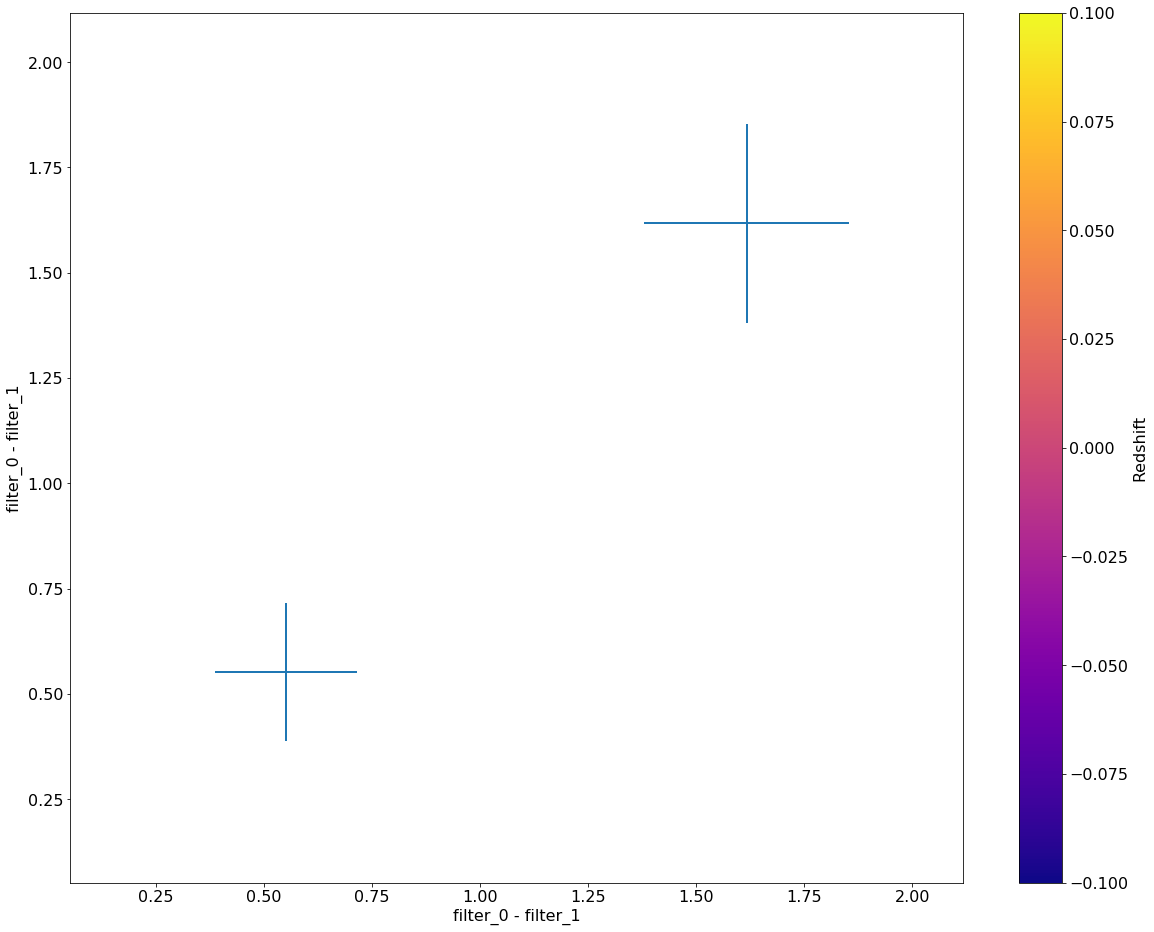

In [14]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.00, 0.0), fig=fig)

In [15]:
sig_plot.filter_dict.magListForSed(blue_spec), sig_plot.filter_dict.magListForSed(red_spec)

(array([-18.16520202, -18.76066126]), array([-17.78854227, -19.49390056]))

### Make sigmoid filter plot

In [16]:
sig_spec = s.get_sigmoid_spectrum()

In [17]:
sig_spec.wavelen[np.where(sig_spec.flambda < 0.01)] = 0.01

In [18]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**1.5)))

Text(0, 0.5, 'Prior Probability')

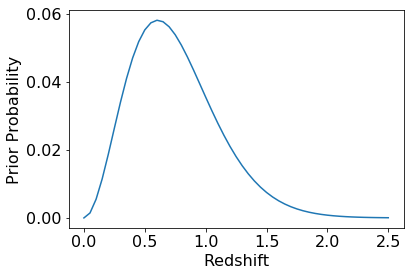

In [19]:
plt.plot(np.arange(0.00, 2.51, 0.05), prior_z(np.arange(0.00, 2.51, 0.05)))
plt.xlabel('Redshift')
plt.ylabel('Prior Probability')

(200, 500)

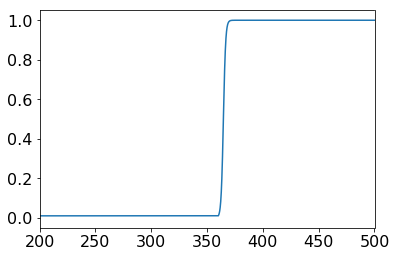

In [20]:
plt.plot(sig_spec.wavelen, sig_spec.flambda)
plt.xlim(200, 500)

In [21]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [22]:
ref_filter = Bandpass()
ref_filter.imsimBandpass()

In [23]:
sig_example = siggi([sig_spec], [1.0], prior_z,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [24]:
%%time
test_rand_state = np.random.RandomState(2325)
num_filters = 2
set_ratio = 0.5
res_2 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=4, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 758 out of 758 | elapsed:  7.1min finished


-2.361379888469708 758
CPU times: user 2min 15s, sys: 43.3 s, total: 2min 58s
Wall time: 8min 36s


In [25]:
min_idx = np.argmin(res_2.yi[:-3])
best_pt = res_2.Xi[min_idx]
print(best_pt, res_2.yi[min_idx])

[550.0, 650.0, 700.0, 800.0] -1.6151758556896496


In [26]:
sig_spec.redshiftSED(0.6)
sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0, sky_mag=21.2)

Text(0, 0.5, 'Filter 2 Center Wavelength (nm)')

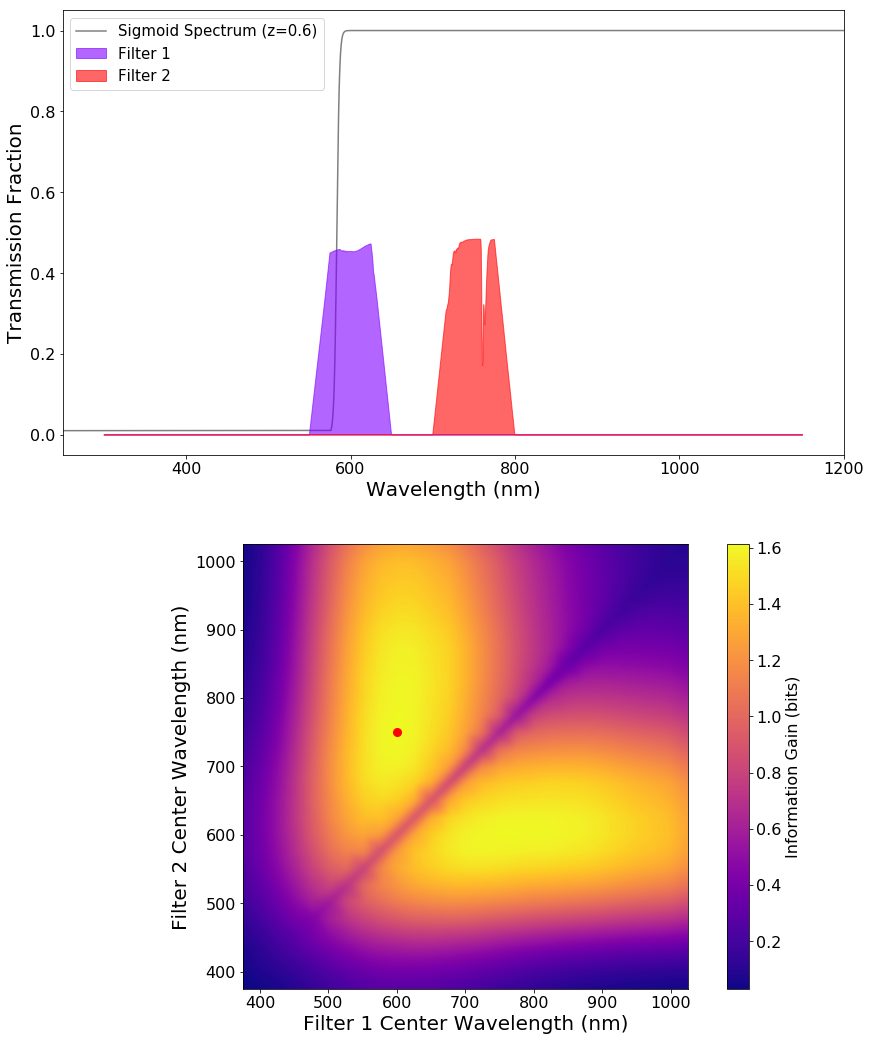

In [27]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Sigmoid Spectrum (z=0.6)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_2.Xi[:-3], np.abs(res_2.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
#plt.savefig('Example_2.pdf')

In [28]:
frozen_dict = BandpassDict.loadTotalBandpassesFromFiles(
                            bandpassDir='../siggi/data/lsst_baseline_throughputs')

In [30]:
from copy import deepcopy
shift_seds = []

sig_spec = s.get_sigmoid_spectrum()
sig_spec.flambda[np.where(sig_spec.flambda < 0.01)] = 0.01

#best_pt = [350., 450., 400., 500.]
#best_pt = [800., 900., 900., 1000.]
#best_pt = [600.0, 700.0, 825.0, 925.0]

sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0, sky_mag=21.2)

for sed_obj in [sig_spec]:
    for z_val in np.linspace(0.05, 2.5, 50):
        sed_copy = deepcopy(sed_obj)
        f_norm = sed_copy.calcFluxNorm(22., 
                                       frozen_dict['r'])
        sed_copy.multiplyFluxNorm(f_norm)
        sed_copy.redshiftSED(z_val, dimming=True)
        shift_seds.append(sed_copy)

calc_ig = calcIG(sig_plot.filter_dict, shift_seds,
                         np.ones(len(shift_seds)),
                         sky_mag=21.2)
col_x, err_x = calc_ig.calc_colors()


Text(0, 0.5, 'Color ($F_2$ - $F_{1}$)')

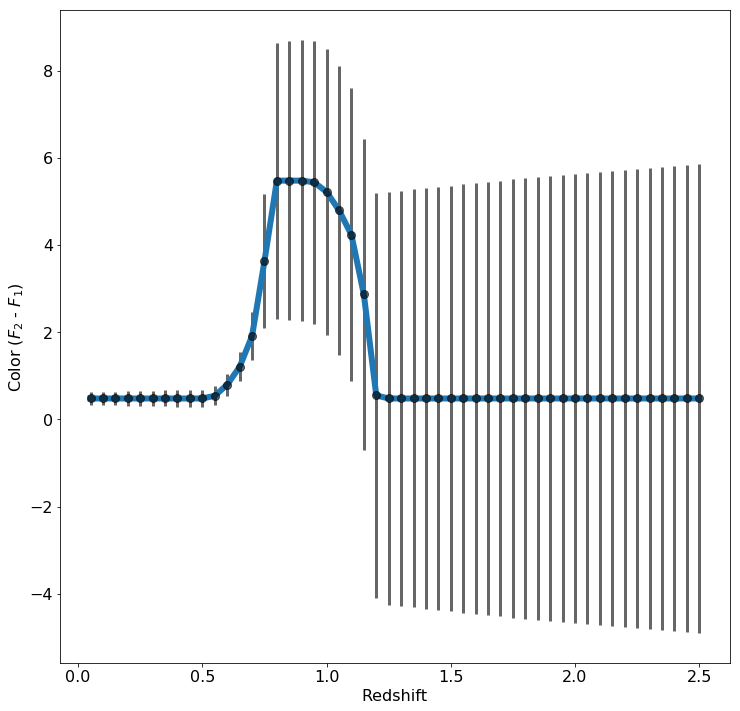

In [31]:
fig = plt.figure(figsize=(12,12))
plt.plot(np.linspace(0.05, 2.5, 50), col_x, lw=6)
plt.errorbar(np.linspace(0.05, 2.5, 50), col_x, yerr=err_x, ls='', marker='o', color='k', lw=3, alpha=0.6, ms=8)
plt.xlabel('Redshift')
plt.ylabel(r'Color ($F_2$ - $F_{1}$)')
#plt.savefig('example_2_errors.pdf')

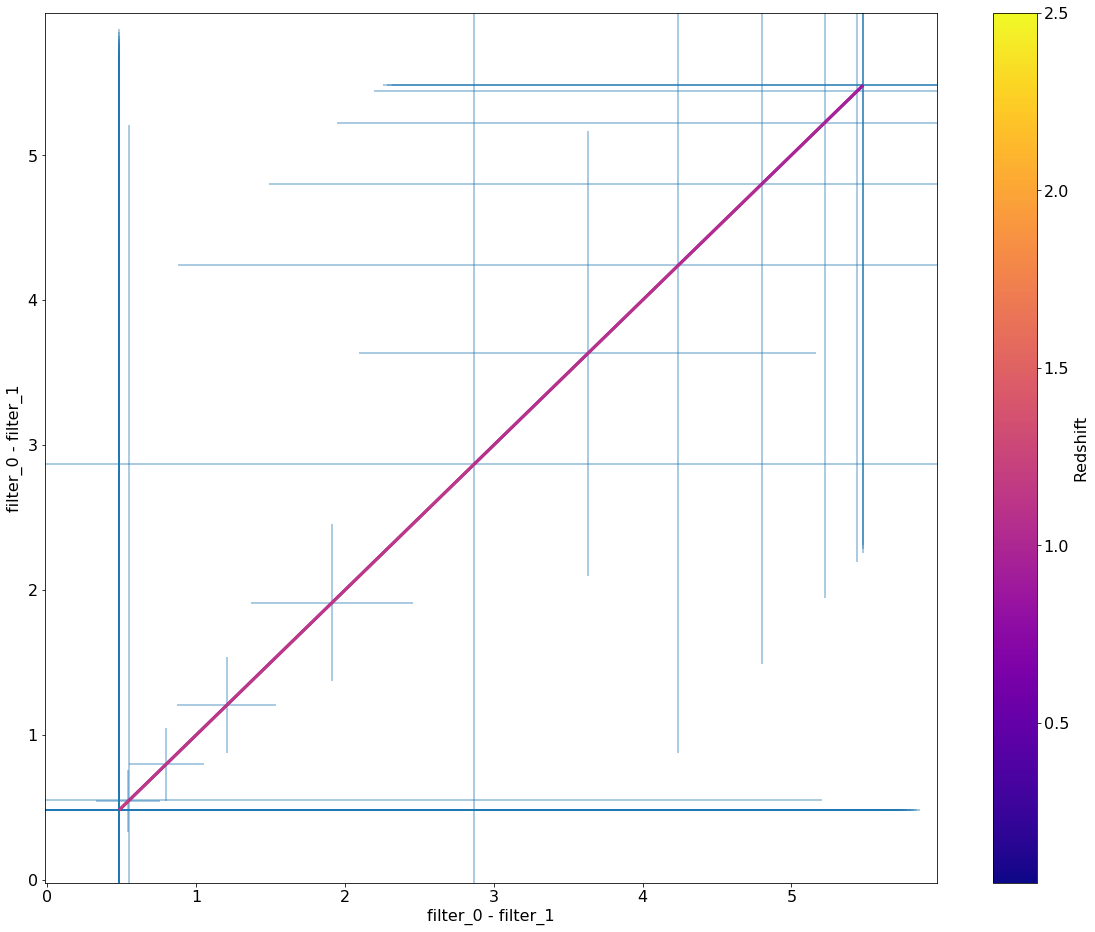

In [32]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.05, 2.5, 50), fig=fig)

## Example 3

In [33]:
blue_spec = s.get_blue_spectrum()

In [34]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [35]:
sig_example = siggi([blue_spec], [1.0], prior_z,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [36]:
%%time
test_rand_state = np.random.RandomState(864)
num_filters = 2
set_ratio = 0.5
res_3 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=4, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 758 out of 758 | elapsed:  6.0min finished


-2.459294325285125 758
CPU times: user 2min 38s, sys: 4.26 s, total: 2min 42s
Wall time: 7min 49s


In [37]:
min_idx = np.argmin(res_3.yi[:-3])
best_pt = res_3.Xi[min_idx]
print(best_pt, res_3.yi[min_idx])

[525.0, 625.0, 825.0, 925.0] -2.0297861137802204


In [38]:
res_3.Xi[114], res_3.yi[114]

([425.0, 525.0, 475.0, 575.0], -0.540722849287179)

In [39]:
# Uncomment if blue and red filters are reversed
#best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [40]:
blue_spec.redshiftSED(0.6)
sig_plot = plotting([blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0, sky_mag=21.2)

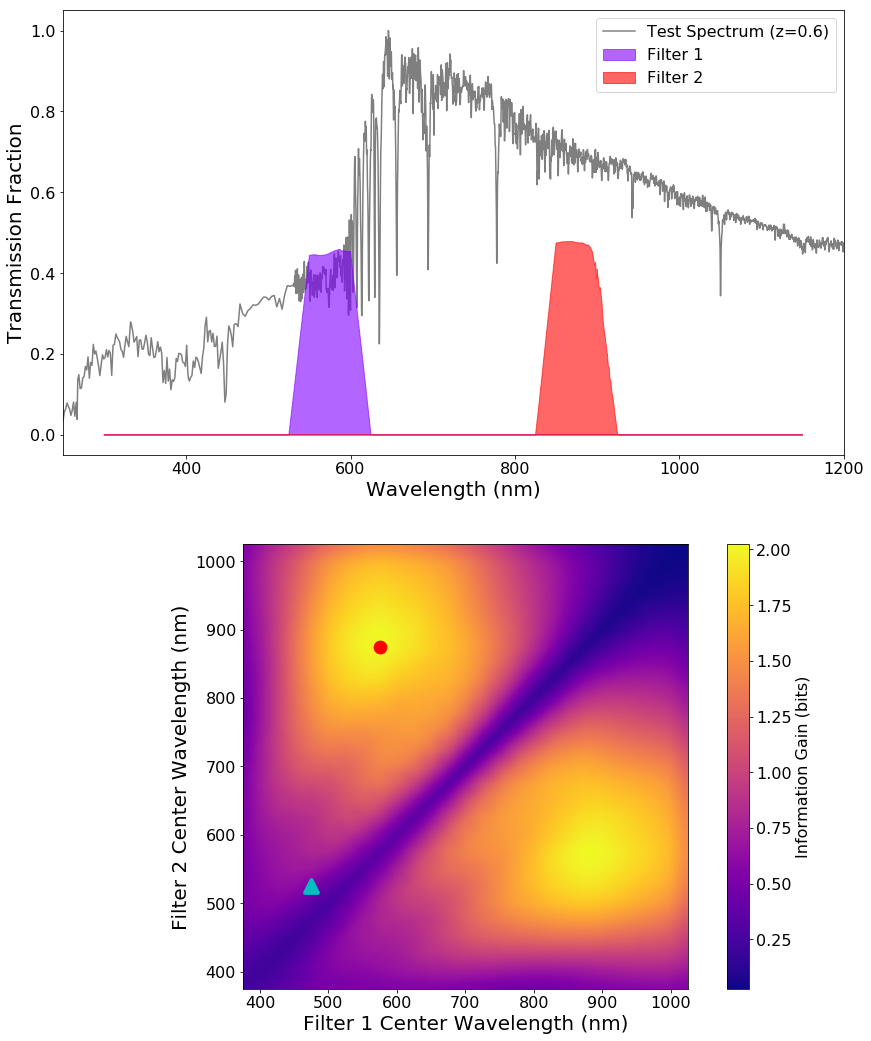

In [42]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Test Spectrum (z=0.6)', 'Filter 1', 'Filter 2'), loc=1)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_3.Xi[:-3], np.abs(res_3.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=164)
plt.scatter(475., 525., c='c', s=164, marker='^', lw=4)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
#plt.savefig('Example_3.pdf')

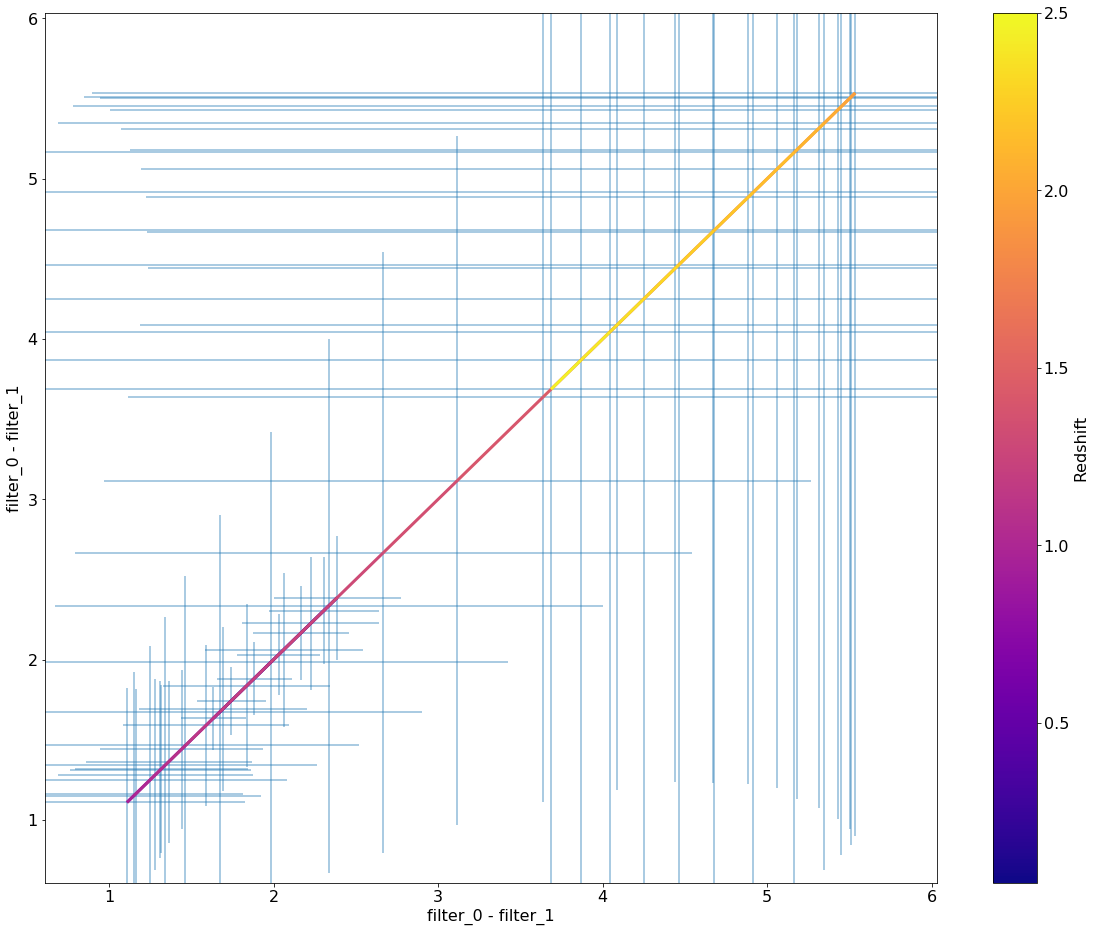

In [43]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.05, 2.5, 50), fig=fig)

In [44]:
from copy import deepcopy
shift_seds = []

sig_spec = s.get_blue_spectrum()
sig_spec.flambda[np.where(sig_spec.flambda < 0.01)] = 0.01

#best_pt = [350., 450., 400., 500.]
#best_pt = [800., 900., 900., 1000.]
#best_pt = [600.0, 700.0, 825.0, 925.0]

sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0, sky_mag=21.2)

for sed_obj in [sig_spec]:
    for z_val in np.linspace(0.05, 2.5, 50):
        sed_copy = deepcopy(sed_obj)
        f_norm = sed_copy.calcFluxNorm(22., 
                                       frozen_dict['r'])
        sed_copy.multiplyFluxNorm(f_norm)
        sed_copy.redshiftSED(z_val, dimming=True)
        shift_seds.append(sed_copy)

calc_ig = calcIG(sig_plot.filter_dict, shift_seds,
                         np.ones(len(shift_seds)),
                         sky_mag=21.2)
col_x, err_x = calc_ig.calc_colors()
#print(col_x)


Text(0, 0.5, 'Color ($F_2$ - $F_{1}$)')

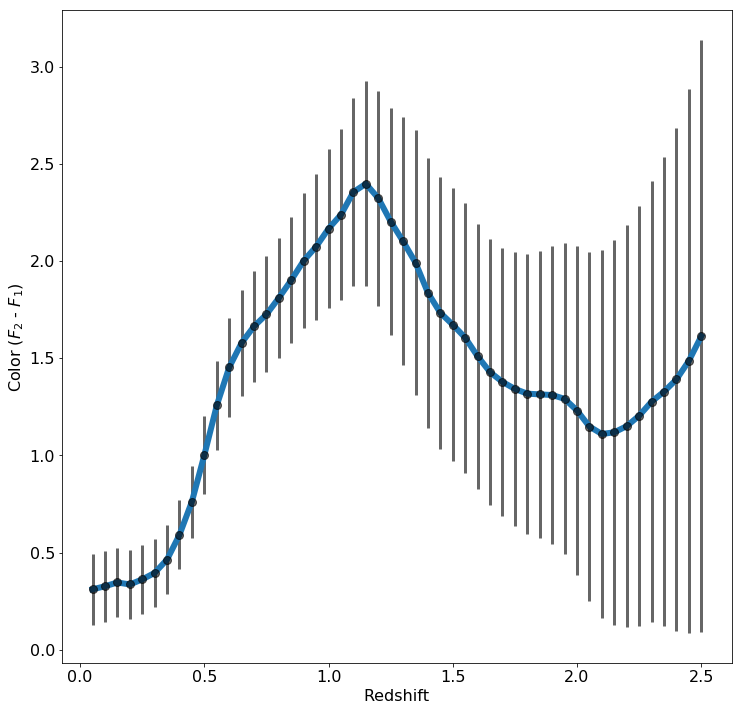

In [45]:
fig = plt.figure(figsize=(12,12))
plt.plot(np.linspace(0.05, 2.5, 50), col_x, lw=6)
plt.errorbar(np.linspace(0.05, 2.5, 50), col_x, yerr=err_x, ls='', marker='o', color='k', lw=3, alpha=0.6, ms=8)
plt.xlabel('Redshift')
plt.ylabel(r'Color ($F_2$ - $F_{1}$)')
#plt.savefig('example_3_errors.pdf')

In [46]:
prior_vals = []
for z_val in np.linspace(0.05, 2.5, 50):
    prior_vals.append(prior_z(z_val))

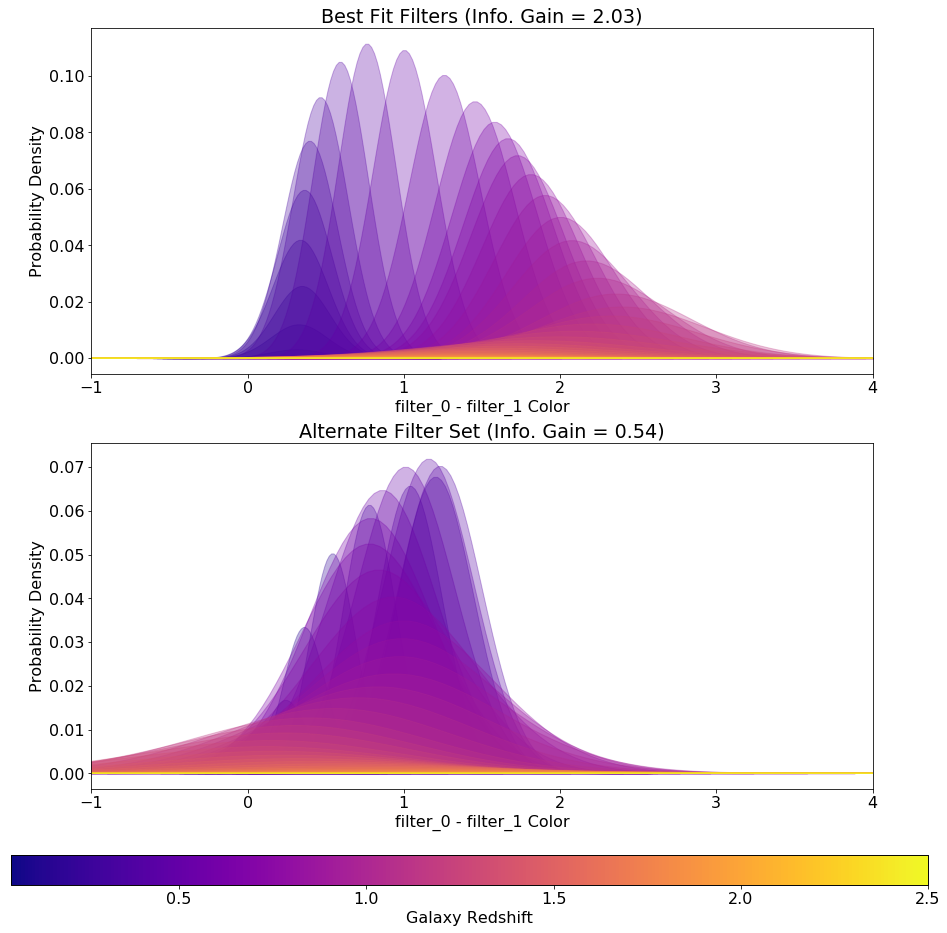

In [56]:
blue_spec = s.get_blue_spectrum()
fig = plt.figure(figsize=(14, 14))
fig.add_subplot(2,1,1)
plt.title('Best Fit Filters (Info. Gain = 2.03)')
plt.xlim(-1, 4)
sig_plot = plotting([blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5, sed_mags=22., sky_mag=21.2)
sig_plot.plot_color_distributions(['filter_0', 'filter_1'], np.linspace(0.05, 2.5, 50), fig=fig, add_cbar=True, include_prior=prior_z)
fig.add_subplot(2,1,2)
plt.title('Alternate Filter Set (Info. Gain = 0.54)')
plt.xlim(-1, 4)
sig_plot = plotting([blue_spec], [425.0, 525.0, 525.0, 625.0],
                    frozen_filt_dict=None, set_ratio=0.5, sed_mags=22., sky_mag=21.2)
sig_plot.plot_color_distributions(['filter_0', 'filter_1'], np.linspace(0.05, 2.5, 50), fig=fig, add_cbar=True, include_prior=prior_z)
#plt.tight_layout()
plt.savefig('example_3_color_plot.pdf')